## Manuscript figures
This notebook can be used to plot figures in the manuscript. Please note that we use bigger values for the population_size, number of networks, num of replicates for the figures in the paper, computations fow which were done on a cluster. Here we work with smaller values for the above mentioned parameters for computational ease.

We first generate networks, then place anti-conformists on the network to initialize the configuration for the simulations


In [1]:
import time
import itertools
import multiprocessing as mp
from one_run_net import one_run_network
from one_run_net_dynamic import one_run_network_dynamic
from one_run_wm import one_run_well_mixed
import numpy as np
from conformity_placement_on_network import conformity_placement_on_network
from adjacency_matrix_generator import adjacency_matrix_generator
import networkx as nx
from numba import njit
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
p = mp.Pool(processes=15)


In [ ]:
# N :population size
# num_of_iter : maximum number of iterations
# num_of_replicatres : number of replicates
# x0A : intial fraction of population with choice A
# O: strengths of the two preferences in the population e.g. [10,-10]; postive (negative) value indicating preference for A(B)  
# frac_w : fration of anti-conformists
# frac_oA : fraction of population preferring A
# beta : inverse temperature of fermi update function 
# A : adjacency matrix of the network of the population
# w : list of conformities of agents 

In [3]:
N=1000
z=20
num_of_iter=N*150
num_of_networks=10
num_of_replicates=5
param_spacing=15


#list of fraction of anti-conformists in the population
param_list=np.linspace(0.02,0.5,param_spacing)


x0_spacing=10

#list of initial conditions for simulations
x0_list= np.linspace(0,1,x0_spacing)


O=np.array([10,-10])


frac_oA=0.5

conformity=np.array([-1,1])
  

beta=100




## Generate adjacency matrices

In [4]:
#choose network topology [1-ER, 2-BA] 
network=2
rnd=666
rnd_list=range(666,666+num_of_networks)
input_list= np.array([(network,N,z,rnd) for rnd in rnd_list], dtype=object)
A_list=p.starmap(adjacency_matrix_generator,input_list)

## Generate configurations with varying placement of anti-conformists on the network  

In [4]:

hipsters_on_hubs=0

k_w_corr_list=[0]
corr_spacing=len(k_w_corr_list)
input_list = [(hipsters_on_hubs,N,frac_w,k_w_corr,A,conformity) for frac_w,k_w_corr,A in itertools.product (param_list,k_w_corr_list,A_list)]
config_list = p.starmap(conformity_placement_on_network,input_list)

config_list=np.array(config_list)
config_list.shape=(param_spacing,corr_spacing,num_of_networks,N)

(150, 500)


## Figure 2A

In [5]:
input_list = np.array([(N,num_of_iter,num_of_replicates,x0A,O,param_list[i],frac_oA,beta,A_list[iii],config_list[i,ii,iii]) for i,ii,x0A,iii in itertools.product (range(param_spacing),range(corr_spacing),x0_list,range(num_of_networks))], dtype=object)


st = time.time()

xa,volatility,align =zip(*p.starmap(one_run_network,input_list))

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 31.973223209381104 seconds


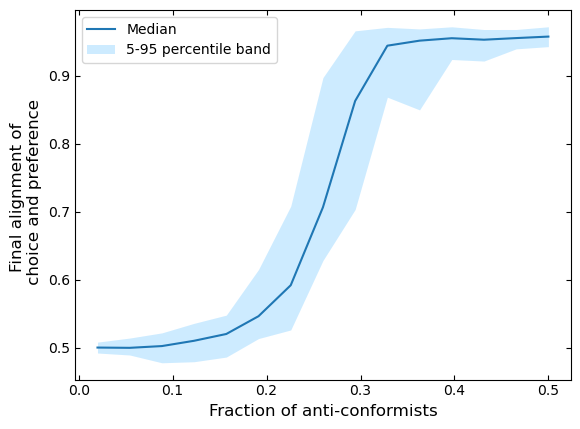

In [7]:
plt.style.use("default")
# correlation between choice and preferene
fig, ax = plt.subplots()


align=np.array(align)
align.shape = (param_spacing,x0_spacing,num_of_networks)
temp=align
mean=np.median(temp,axis=(1,2))

percentile_95=np.percentile(temp,95,axis=(1,2))
percentile_5=np.percentile(temp,5,axis=(1,2))

ax.plot(param_list, mean,label='Median')
ax.fill_between(param_list,percentile_5,percentile_95, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',linewidth=0,label='5-95 percentile band')


# plt.axvline(x=critical_value, color='k',ls='--', lw=1, label='Theoretical critical value')
plt.legend()
ax.set_xlabel("Fraction of anti-conformists", fontsize=12)
# #ax.set_ylabel("Correlation between  choice and preference", fontsize=10)
ax.set_ylabel("Final alignment of \n choice and preference", fontsize=12)
ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")

# Figure 2B


In [8]:
hipsters_on_hubs=1
param_list=np.linspace(0.02,0.3,param_spacing)
k_w_corr_list=np.linspace(0.02,0.8,param_spacing)

corr_spacing=len(k_w_corr_list)input_list = [(hipsters_on_hubs,N,frac_w,k_w_corr,A,conformity) for frac_w,k_w_corr,A in itertools.product (param_list,k_w_corr_list,A_list)]
config_list = p.starmap(conformity_placement_on_network,input_list)

config_list=np.array(config_list)
config_list.shape=(param_spacing,corr_spacing,num_of_networks,N)


In [9]:
input_list = np.array([(N,num_of_iter,num_of_replicates,x0A,O,param_list[i],frac_oA,beta,A_list[iii],config_list[i,ii,iii]) for i,ii,x0A,iii in itertools.product (range(param_spacing),range(corr_spacing),x0_list,range(num_of_networks))], dtype=object)


st = time.time()

xa,volatility,align =zip(*p.starmap(one_run_network,input_list))

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 466.6298260688782 seconds


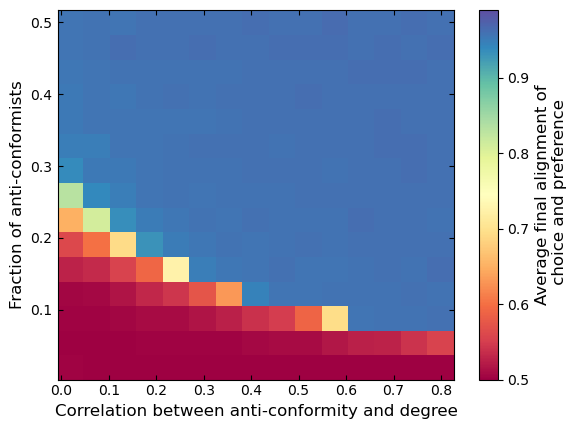

In [10]:

align=np.array(align)
align.shape = (param_spacing,len(k_w_corr_list),x0_spacing*num_of_networks)
mean_align=np.median(align,axis=2)
fig, ax = plt.subplots()
cmap = mpl.cm.Spectral
plt.pcolor(k_w_corr_list,param_list,  mean_align, cmap=cmap,shading='auto', vmin=0.5, vmax=0.99)


cbar=plt.colorbar()


ax.set_xlabel(r'Correlation between anti-conformity and degree', fontsize=12)
#ax.set_ylabel(r'fraction of A preference ', fontsize=15)
ax.set_ylabel(r'Fraction of anti-conformists', fontsize=12)
#ax.set_ylabel(r'parameter p for WS network', fontsize=15)
cbar.ax.set_ylabel('Average final alignment of\n choice and preference', rotation=90, fontsize=12)
ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")

## Figure 3A


In [5]:
num_of_iter=N*20
linear=1
x0A=1
freq=2/(N*5)

o=np.ones(num_of_iter, dtype=np.float64)

for i in range(num_of_iter):
    if linear==1:
        o[i]= 10*(1 - i*freq)
        if o[i]<=-10.0:
            o[i]=-10.0
    else:
        o[i]=10*np.sin((i*2*np.pi*freq))

hipsters_on_hubs=0

param_spacing=7
param_list=np.linspace(0.2,0.5,param_spacing)
k_w_corr_list=[0]
corr_spacing=len(k_w_corr_list)

input_list = [(hipsters_on_hubs,N,frac_w,k_w_corr,A,conformity) for frac_w,k_w_corr,A in itertools.product (param_list,k_w_corr_list,A_list)]
config_list = p.starmap(conformity_placement_on_network,input_list)

config_list=np.array(config_list)
config_list.shape=(param_spacing,corr_spacing,num_of_networks,N)

In [7]:

input_list = np.array([(N,num_of_iter,x0A,param_list[i],beta,A_list[iii],config_list[i,ii,iii],o) for i,ii,iii in itertools.product (range(param_spacing),range(corr_spacing),range(num_of_networks))], dtype=object)


accuracy_a,accuracy_c,x1_a,x1_c,x =zip(*p.starmap(one_run_network_dynamic,input_list))

(0.0, 1.05)

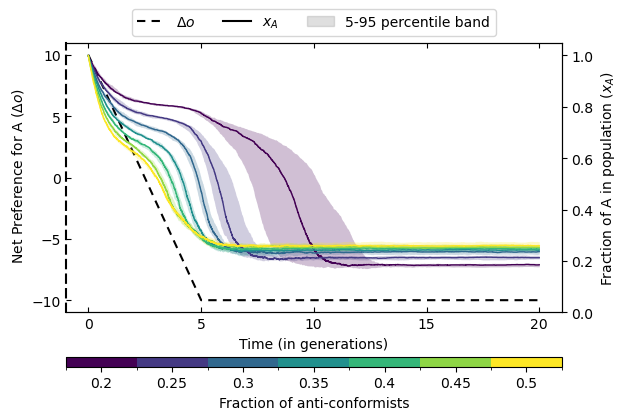

In [8]:
x=np.array(x)
x.shape = (param_spacing,num_of_networks,num_of_iter)

fig, ax = plt.subplots()
ax2 = ax.twinx()

cmap = mpl.cm.viridis
for i in range(param_spacing):
    mean=np.median(x[i,:],0)
    percentile_95=np.percentile(x[i,:,:],95,axis=0)
    percentile_5=np.percentile(x[i,:,:],5,axis=0)
    error_low = abs(mean - percentile_5)
    error_high = abs(percentile_95 - mean)
    std=np.std(x[i,:,:],0)
    ax2.plot(np.array(range(num_of_iter))/N, mean,color=cmap((param_list[i]-min(param_list))/(max(param_list)-min(param_list))),linewidth=1)
    
    ax2.fill_between(np.array(range(num_of_iter))/N,percentile_5, percentile_95,alpha=0.25, edgecolor='#CC4F1B', facecolor=cmap((param_list[i]-min(param_list))/(max(param_list)-min(param_list))),linewidth=0)


#plt.legend()

        
ax.plot(np.array(range(num_of_iter))/N,o,c='k',linewidth=1.5,linestyle='--',dashes=(4, 3),label='$Δo$')
ax.spines["left"].set_linestyle((0,(4,3)))
#ax.spines["left"].set_linestyle("--")
ax.spines["left"].set_linewidth(1.5)
ax2.spines["left"].set_visible(False)

line1 = Line2D([0], [0], label='Conformists', color='k')
patch1 = mpatches.Patch(color='grey',alpha=0.25, label='5-95 percentile band')
temp=np.ones(param_spacing+1)
temp[0]=param_list[0]-0.5*(param_list[1]-param_list[0])
temp[1:]=[i + 0.5 * np.diff(param_list)[0] for i in param_list]
norm = mpl.colors.BoundaryNorm(temp, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#cbar=fig.colorbar(sm, orientation = 'horizontal',pad=0.12,ticks=param_list, label="Correlation b/w degree and anti-conformity",aspect=50)
cbar=fig.colorbar(sm, orientation = 'horizontal',pad=0.12,ticks=param_list, label="Fraction of anti-conformists",aspect=50,ax=plt.gca())
cbar.ax.set_xticklabels([str(round(i, 2)) for i in param_list])

handles1, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='$x_A$', color='k')
handles1.extend([line1,patch1])
lgd=plt.legend(handles=handles1,loc='upper center',fontsize="10", bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True)


ax2.set_ylabel("Fraction of A in population ($x_A$)", fontsize=10)
ax.set_ylabel(" Net Preference for A ($Δ o$)", fontsize=10)
ax.set_yticks(np.arange(-10, 10.1, step=5.0))
ax.set_xticks(np.arange(0, 20.1, step=5.0))


ax.set_xlabel("Time (in generations)", fontsize=10)
#ax.set_ylabel("Correlation between  choice and preference", fontsize=10)


ax.tick_params(bottom=True, top=True, left=True, right=False,direction="in")

ax2.set_ylim(0.00,1.05)


## Figure 3B

In [20]:
param_spacing=1
corr_spacing=7
param_list=[0.15]

hipsters_on_hubs=1

k_w_corr_list=np.linspace(0.1,0.8,corr_spacing)
corr_spacing=len(k_w_corr_list)

input_list = [(hipsters_on_hubs,N,frac_w,k_w_corr,A,conformity) for frac_w,k_w_corr,A in itertools.product (param_list,k_w_corr_list,A_list)]
config_list = p.starmap(conformity_placement_on_network,input_list)

config_list=np.array(config_list)
config_list.shape=(param_spacing,corr_spacing,num_of_networks,N)

In [21]:

input_list = np.array([(N,num_of_iter,x0A,param_list[i],beta,A_list[iii],config_list[i,ii,iii],o) for i,ii,iii in itertools.product (range(param_spacing),range(corr_spacing),range(num_of_networks))], dtype=object)


accuracy_a,accuracy_c,x1_a,x1_c,x =zip(*p.starmap(one_run_network_dynamic,input_list))

(0.0, 1.05)

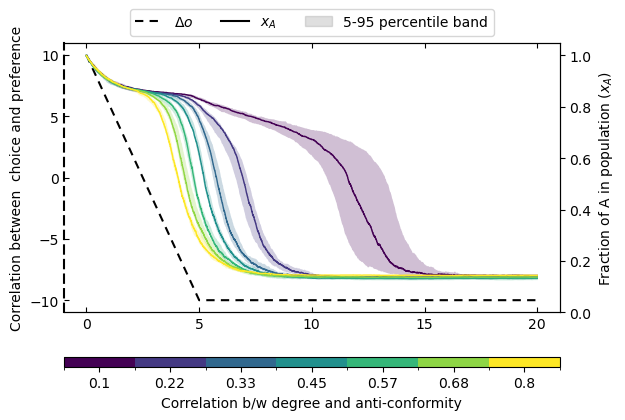

In [24]:
x=np.array(x)
x.shape = (corr_spacing,num_of_networks,num_of_iter)

fig, ax = plt.subplots()
ax2 = ax.twinx()
param_list=k_w_corr_list
param_spacing=corr_spacing


cmap = mpl.cm.viridis
for i in range(param_spacing):
    mean=np.median(x[i,:],0)
    percentile_95=np.percentile(x[i,:,:],95,axis=0)
    percentile_5=np.percentile(x[i,:,:],5,axis=0)
    error_low = abs(mean - percentile_5)
    error_high = abs(percentile_95 - mean)
    std=np.std(x[i,:,:],0)
    ax2.plot(np.array(range(num_of_iter))/N, mean,color=cmap((param_list[i]-min(param_list))/(max(param_list)-min(param_list))),linewidth=1)
    
    ax2.fill_between(np.array(range(num_of_iter))/N,percentile_5, percentile_95,alpha=0.25, edgecolor='#CC4F1B', facecolor=cmap((param_list[i]-min(param_list))/(max(param_list)-min(param_list))),linewidth=0)


#plt.legend()

        
ax.plot(np.array(range(num_of_iter))/N,o,c='k',linewidth=1.5,linestyle='--',dashes=(4, 3),label='$Δo$')
ax.spines["left"].set_linestyle((0,(4,3)))
#ax.spines["left"].set_linestyle("--")
ax.spines["left"].set_linewidth(1.5)
ax2.spines["left"].set_visible(False)

line1 = Line2D([0], [0], label='Conformists', color='k')
patch1 = mpatches.Patch(color='grey',alpha=0.25, label='5-95 percentile band')
temp=np.ones(param_spacing+1)
temp[0]=param_list[0]-0.5*(param_list[1]-param_list[0])
temp[1:]=[i + 0.5 * np.diff(param_list)[0] for i in param_list]
norm = mpl.colors.BoundaryNorm(temp, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar=fig.colorbar(sm, orientation = 'horizontal',pad=0.12,ticks=param_list, label="Correlation b/w degree and anti-conformity",aspect=50,ax=plt.gca())
#cbar=fig.colorbar(sm, orientation = 'horizontal',pad=0.12,ticks=param_list, label="Fraction of anti-conformists",aspect=50,ax=plt.gca())
cbar.ax.set_xticklabels([str(round(i, 2)) for i in param_list])

handles1, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='$x_A$', color='k')
handles1.extend([line1,patch1])
lgd=plt.legend(handles=handles1,loc='upper center',fontsize="10", bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True)


ax2.set_ylabel("Fraction of A in population ($x_A$)", fontsize=10)
ax.set_ylabel(" Net Preference for A ($Δ o$)", fontsize=10)
ax.set_yticks(np.arange(-10, 10.1, step=5.0))
ax.set_xticks(np.arange(0, 20.1, step=5.0))


#ax.set_xlabel("Time (in generations)", fontsize=10)
ax.set_ylabel("Correlation between  choice and preference", fontsize=10)


ax.tick_params(bottom=True, top=True, left=True, right=False,direction="in")

ax2.set_ylim(0.00,1.05)


## Figure 4A

In [37]:
num_of_iter=N*24
linear=0
x0A=0.5
freq=1/(N*8)

o=np.ones(num_of_iter, dtype=np.float64)

for i in range(num_of_iter):
    if linear==1:
        o[i]= 10*(1 - i*freq)
        if o[i]<=-10.0:
            o[i]=-10.0
    else:
        o[i]=10*np.sin((i*2*np.pi*freq))

hipsters_on_hubs=1

k_w_corr_list=np.array([0.05,0.2,0.8])
param_list=[0.2]
corr_spacing=len(k_w_corr_list)
param_spacing=1

input_list = [(hipsters_on_hubs,N,frac_w,k_w_corr,A,conformity) for frac_w,k_w_corr,A in itertools.product (param_list,k_w_corr_list,A_list)]
config_list = p.starmap(conformity_placement_on_network,input_list)

config_list=np.array(config_list)
config_list.shape=(param_spacing,corr_spacing,num_of_networks,N)

In [38]:

input_list = np.array([(N,num_of_iter,x0A,param_list[i],beta,A_list[iii],config_list[i,ii,iii],o) for i,ii,iii in itertools.product (range(param_spacing),range(corr_spacing),range(num_of_networks))], dtype=object)


accuracy_a,accuracy_c,x1_a,x1_c,x =zip(*p.starmap(one_run_network_dynamic,input_list))

(-0.05, 1.05)

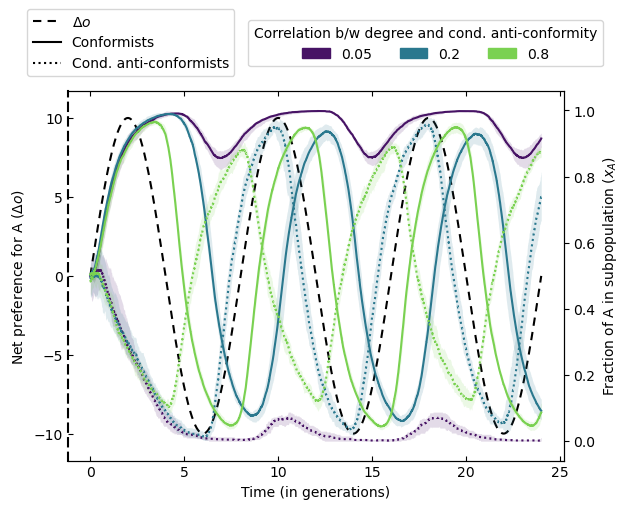

In [42]:
param_list=k_w_corr_list
param_spacing=corr_spacing
cmap = mpl.cm.viridis
fig, ax = plt.subplots()
ax2 = ax.twinx()

ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


c_list=param_list

c_list[1]=0.4




CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
               '#f781bf', '#a65628', '#984ea3',
               '#999999', '#e41a1c', '#dede00']

x_c=np.array(x1_c)
x_c.shape = (param_spacing,num_of_networks,num_of_iter)
x_a=np.array(x1_a)
x_a.shape = (param_spacing,num_of_networks,num_of_iter)



for i in range(param_spacing):
    mean=np.mean(x_c[i,:,:],0)
    percentile_95=np.percentile(x_c[i,:,:],95,axis=0)
    percentile_5=np.percentile(x_c[i,:,:],5,axis=0)
    
    ax2.plot(np.array(range(num_of_iter))/N, mean,linewidth=1.5,color=cmap(c_list[i]))
    ax2.fill_between(np.array(range(num_of_iter))/N, percentile_5, percentile_95,alpha=0.15, edgecolor='#CC4F1B', facecolor=cmap(c_list[i]),linewidth=0)
    mean=np.mean(x_a[i,:,:],0)
    percentile_95=np.percentile(x_a[i,:,:],95,axis=0)
    percentile_5=np.percentile(x_a[i,:,:],5,axis=0)
    
    ax2.plot(np.array(range(num_of_iter))/N, mean,linestyle='dotted',linewidth=1.5,color=cmap(c_list[i]))
    ax2.fill_between(np.array(range(num_of_iter))/N, percentile_5, percentile_95,alpha=0.15, edgecolor='#CC4F1B', facecolor=cmap(c_list[i]),linewidth=0)


ax.plot(np.array(range(num_of_iter))/N,o,c='k',linewidth=1.5,linestyle='--',dashes=(4, 3),label='$Δ o$')

norm = mpl.colors.Normalize(vmin=min(param_list), vmax=max(param_list))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax2.set_ylabel("Fraction of A in subpopulation ($x_A$)", fontsize=10)
ax.set_ylabel("Net preference for A ($Δ o$)", fontsize=10)

ax.set_xlabel("Time (in generations)", fontsize=10)


handles1, labels = ax.get_legend_handles_labels()

handles2, labels = ax2.get_legend_handles_labels()
ax.spines["left"].set_linestyle((0,(4,3)))

ax.spines["left"].set_linewidth(1.5)
ax2.spines["left"].set_visible(False)

ax.set_yticks(np.arange(-10, 10.1, step=5.0))
line1 = Line2D([0], [0], label='Conformists', color='k')
line2 = Line2D([0], [0], label='Cond. anti-conformists', color='k',linestyle='dotted')


 #add handles

patch1 = mpatches.Patch(color=cmap(k_w_corr_list[0]), label=str(k_w_corr_list[0]))
patch2 = mpatches.Patch(color=cmap(0.4), label=str(0.2))
patch3 = mpatches.Patch(color=cmap(k_w_corr_list[2]), label=str(k_w_corr_list[2]))

handles1.extend([line1, line2])
handles2.extend([patch1,patch2,patch3])

lgd=ax.legend(handles=handles1,loc='upper right',fontsize="10", bbox_to_anchor=(0.35, 1.24),ncol=1, fancybox=True)
lgd2=ax2.legend(handles=handles2,loc='upper left',title='Correlation b/w degree and cond. anti-conformity',fontsize="10", bbox_to_anchor=(0.35, 1.21),ncol=3, fancybox=True)

ax2.set_ylim(-0.025,1.025)

ratio = 0.70
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


ax.tick_params(bottom=True, top=True, left=True, right=False,direction="in")
ax2.set_ylim(-0.05,1.05)

## Figure 4B


In [49]:
corr_spacing=20
k_w_corr_list=np.linspace(0.01,0.8,corr_spacing)
param_list=[0.2]
frac_w=0.2
param_spacing=1

input_list = [(hipsters_on_hubs,N,frac_w,k_w_corr,A,conformity) for frac_w,k_w_corr,A in itertools.product (param_list,k_w_corr_list,A_list)]
config_list = p.starmap(conformity_placement_on_network,input_list)

config_list=np.array(config_list)
config_list.shape=(param_spacing,corr_spacing,num_of_networks,N)

In [50]:
input_list = np.array([(N,num_of_iter,x0A,param_list[i],beta,A_list[iii],config_list[i,ii,iii],o) for i,ii,iii in itertools.product (range(param_spacing),range(corr_spacing),range(num_of_networks))], dtype=object)


accuracy_a,accuracy_c,x1_a,x1_c,x =zip(*p.starmap(one_run_network_dynamic,input_list))

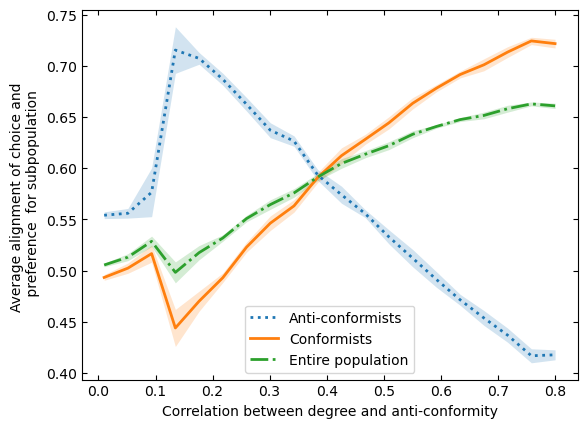

In [53]:
param_list=k_w_corr_list
param_spacing=corr_spacing


accuracy1_a=np.array(accuracy_a)
accuracy1_c=np.array(accuracy_c)
accuracy1_a.shape = (param_spacing,num_of_networks)
accuracy1_c.shape = (param_spacing,num_of_networks)

accuracy=accuracy1_a*frac_w+accuracy1_c*(1-frac_w)


fig, ax = plt.subplots()

mean1=accuracy1_a.mean(axis=1)
sd=accuracy1_a.std(axis=1)

ax.plot(k_w_corr_list, mean1,linewidth=2,label='Anti-conformists',linestyle='dotted')
ax.fill_between(param_list, mean1-sd, mean1+sd,alpha=0.2, edgecolor='#CC4F1B',linewidth=0)

mean1=accuracy1_c.mean(axis=1)
sd=accuracy1_c.std(axis=1)

ax.plot(k_w_corr_list, mean1,linewidth=2,label='Conformists')
ax.fill_between(k_w_corr_list, mean1-sd, mean1+sd,alpha=0.2, edgecolor='#CC4F1B',linewidth=0)



mean1=accuracy.mean(axis=1)
sd=accuracy.std(axis=1)

ax.plot(k_w_corr_list, mean1,linewidth=2,label='Entire population',linestyle='-.')
ax.fill_between(k_w_corr_list, mean1-sd, mean1+sd,alpha=0.2, edgecolor='#CC4F1B',linewidth=0)

plt.legend(loc='lower center', fancybox=True)
#ax.set_xlabel("Fraction of anti-conformists", fontsize=10)
ax.set_xlabel("Correlation between degree and anti-conformity", fontsize=10)
ax.set_ylabel("Average alignment of choice and \n preference  for subpopulation", fontsize=10)
ax.tick_params(which='both',bottom=True, top=True, left=True, right=True,direction="in")